# Chapter 2: Training Your First Model

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['mpg', 'cyl', 'disp', 'hp', 'weight', 'acc', 'year', 'origin']

df = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

shuffled = df.sample(frac=1, random_state=1).reset_index(drop=True)
trainval, test = train_test_split(shuffled, test_size=0.16, shuffle=False)
train, val = train_test_split(trainval, test_size=0.2, shuffle=False)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step2.png)

In [2]:
train.dropna(inplace=True)
val.dropna(inplace=True)
test.dropna(inplace=True)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step3.png)

In [3]:
cont_attr = ['mpg', 'disp', 'hp', 'weight', 'acc']
disc_attr = ['cyl', 'year', 'origin']

train_features = train[cont_attr[1:]]
val_features = val[cont_attr[1:]]
test_features = test[cont_attr[1:]]

In [4]:
from sklearn.preprocessing import StandardScaler

def standardize(df, cont_attr, scaler=None):
    cont_X = df[cont_attr].values
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(cont_X)
    cont_X = scaler.transform(cont_X)
    cont_X = torch.as_tensor(cont_X, dtype=torch.float32)
    return cont_X, scaler

standardized_data = {}
# The training set is used to fit a scaler
standardized_data['train'], scaler = standardize(train_features, cont_attr[1:])
# The scaler is used as argument to the other datasets
standardized_data['val'], _ = standardize(val_features, cont_attr[1:], scaler)
standardized_data['test'], _ = standardize(test_features, cont_attr[1:], scaler)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step4.png)

In [5]:
from torch.utils.data import TensorDataset

hp_idx = cont_attr.index('hp')

train_ds = TensorDataset(standardized_data['train'][:, [hp_idx]], 
                       torch.as_tensor(train[['mpg']].values, dtype=torch.float32))

val_ds = TensorDataset(standardized_data['val'][:, [hp_idx]], 
                       torch.as_tensor(val[['mpg']].values, dtype=torch.float32))

test_ds = TensorDataset(standardized_data['test'][:, [hp_idx]], 
                        torch.as_tensor(test[['mpg']].values, dtype=torch.float32))

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step5.png)

In [6]:
from torch.utils.data import DataLoader

generator = torch.Generator()
train_loader = DataLoader(dataset=train_ds, batch_size=32, drop_last=True, shuffle=True, generator=generator)
val_loader = DataLoader(dataset=val_ds, batch_size=32, drop_last=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32, drop_last=True)

# Sets the seed of the sampler's generator
train_loader.sampler.generator.manual_seed(13)

In [7]:
batch_features, batch_targets = next(iter(train_loader))

## 2.4 Models

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [8]:
import torch.nn as nn

torch.manual_seed(13)
linear = nn.Linear(in_features=1, out_features=1, bias=True)
linear

Linear(in_features=1, out_features=1, bias=True)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch2/linear.png)

### 2.4.1 `state_dict()`


In [9]:
linear.state_dict()

OrderedDict([('weight', tensor([[-0.8164]])), ('bias', tensor([-0.0412]))])

In [10]:
linear.weight, linear.bias

(Parameter containing:
 tensor([[-0.8164]], requires_grad=True),
 Parameter containing:
 tensor([-0.0412], requires_grad=True))

In [11]:
list(linear.parameters())

[Parameter containing:
 tensor([[-0.8164]], requires_grad=True),
 Parameter containing:
 tensor([-0.0412], requires_grad=True)]

### 2.4.3 Sequential Models

In [12]:
model = nn.Sequential()
model

Sequential()

In [13]:
model.add_module('layer1', linear)

In [14]:
model.state_dict()

OrderedDict([('layer1.weight', tensor([[-0.8164]])),
             ('layer1.bias', tensor([-0.0412]))])

In [15]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.8164]], requires_grad=True),
 Parameter containing:
 tensor([-0.0412], requires_grad=True)]

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch2/layers.png)

### 2.4.4 Making Predictions - The Forward Pass

In [18]:
bad_predictions = model(batch_features)
bad_predictions

tensor([[ 0.8935],
        [-0.4606],
        [ 0.7384],
        [ 0.3369],
        [ 0.6453],
        [-1.1931],
        [ 0.9142],
        [-1.8946],
        [ 0.7619],
        [-0.6326],
        [ 0.3463],
        [ 0.5221],
        [ 1.0092],
        [-1.3934],
        [ 0.2635],
        [ 0.7666],
        [-1.4329],
        [-0.6881],
        [ 0.5127],
        [-1.8908],
        [ 0.9076],
        [ 0.9434],
        [-0.0045],
        [-1.4263],
        [ 0.3340],
        [-0.0092],
        [ 1.0769],
        [ 0.2071],
        [ 0.0679],
        [ 0.3999],
        [ 0.2748],
        [-0.9542]], grad_fn=<AddmmBackward0>)

## 2.5 Loss Functions

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step2.png)

In [20]:
error = bad_predictions - batch_targets
error

tensor([[-31.1065],
        [-20.9606],
        [-29.2616],
        [-19.6631],
        [-22.3547],
        [-15.1931],
        [-37.1858],
        [-13.8946],
        [-36.5381],
        [-18.6326],
        [-24.6537],
        [-29.4779],
        [-27.9908],
        [-14.3934],
        [-23.7365],
        [-35.2334],
        [-14.4329],
        [-17.6881],
        [-21.4873],
        [-13.8908],
        [-33.1924],
        [-28.0566],
        [-22.0045],
        [-15.4263],
        [-25.6660],
        [-36.4092],
        [-31.9231],
        [-30.7929],
        [-18.9321],
        [-20.7001],
        [-20.7252],
        [-17.4542]], grad_fn=<SubBackward0>)

In [21]:
(error ** 2).mean()

tensor(630.3235, grad_fn=<MeanBackward0>)

In [24]:
loss_fn = nn.MSELoss()
loss_fn

MSELoss()

In [25]:
loss = loss_fn(bad_predictions, batch_targets)
loss

tensor(630.3235, grad_fn=<MseLossBackward0>)

## 2.6 Gradients and Autograd

In [26]:
weight, bias = list(model.parameters())
weight, bias

(Parameter containing:
 tensor([[-0.8164]], requires_grad=True),
 Parameter containing:
 tensor([-0.0412], requires_grad=True))

In [27]:
modified_predictions = (weight + 0.01) * batch_features + bias
modified_predictions

tensor([[ 0.8821],
        [-0.4554],
        [ 0.7288],
        [ 0.3322],
        [ 0.6369],
        [-1.1790],
        [ 0.9025],
        [-1.8719],
        [ 0.7521],
        [-0.6254],
        [ 0.3415],
        [ 0.5152],
        [ 0.9963],
        [-1.3768],
        [ 0.2598],
        [ 0.7567],
        [-1.4158],
        [-0.6802],
        [ 0.5059],
        [-1.8682],
        [ 0.8960],
        [ 0.9313],
        [-0.0049],
        [-1.4093],
        [ 0.3294],
        [-0.0096],
        [ 1.0632],
        [ 0.2040],
        [ 0.0666],
        [ 0.3945],
        [ 0.2709],
        [-0.9431]], grad_fn=<AddBackward0>)

In [28]:
modified_loss = loss_fn(modified_predictions, batch_targets)
modified_loss

tensor(630.4748, grad_fn=<MseLossBackward0>)

In [29]:
ratio = (modified_loss - loss) / 0.01
ratio

tensor(15.1245, grad_fn=<DivBackward0>)

### 2.6.1 `backward()`

In [30]:
loss.backward()

In [31]:
model.layer1.weight.grad, model.layer1.bias.grad

(tensor([[15.1187]]), tensor([-48.0661]))

In [32]:
updated_weight = model.layer1.weight - 1.0 * model.layer1.weight.grad
updated_bias = model.layer1.bias - 1.0 * model.layer1.bias.grad
updated_weight, updated_bias

(tensor([[-15.9350]], grad_fn=<SubBackward0>),
 tensor([48.0249], grad_fn=<SubBackward0>))

In [33]:
factor = 0.1
updated_weight = model.layer1.weight - factor * model.layer1.weight.grad
updated_bias = model.layer1.bias - factor * model.layer1.bias.grad
updated_weight, updated_bias

(tensor([[-2.3282]], grad_fn=<SubBackward0>),
 tensor([4.7654], grad_fn=<SubBackward0>))

In [40]:
updated_predictions = updated_weight * batch_features + updated_bias
updated_loss = loss_fn(updated_predictions, batch_targets)
updated_loss

tensor(402.9746, grad_fn=<MseLossBackward0>)

### 2.6.2 Learning Rate

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch2/learning_rates.png)

## 2.7 Optimizers

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step3.png)

In [34]:
import torch.optim as optim
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

In [35]:
optimizer.step()

In [36]:
model.state_dict()

OrderedDict([('layer1.weight', tensor([[-2.3282]])),
             ('layer1.bias', tensor([4.7654]))])

In [44]:
optimizer.zero_grad()

### 2.7.1 Adam

In [37]:
optimizer = optim.Adam(params=model.parameters(), lr=0.1)

### 2.7.2 `state_dict()`

In [38]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.1,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': False,
   'params': [0, 1]}]}

## 2.8 The Raw Training Loop

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step4.png)

In [39]:
torch.manual_seed(13)
linear = nn.Linear(in_features=1, out_features=1, bias=True)

model = nn.Sequential()
model.add_module('layer1', linear)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.1)

In [40]:
# Sprinkles
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

train_loader.sampler.generator.manual_seed(13)

for batch_features, batch_targets in train_loader:
    # Sprinkles
    model.train()
    batch_features = batch_features.to(device)
    batch_targets = batch_targets.to(device)
    
    # Step 1 - forward pass
    predictions = model(batch_features)
    
    # Step 2 - computing the loss
    loss = loss_fn(predictions, batch_targets)
    
    # Step 3 - computing the gradients
    loss.backward()
    
    # Step 4 - updating parameters and zeroing gradients
    optimizer.step()
    optimizer.zero_grad()

### 2.8.2 Training Mode

In [41]:
loss

tensor(609.6074, grad_fn=<MseLossBackward0>)

In [42]:
n_epochs = 100

losses = torch.empty(n_epochs)

model.to(device)

for epoch in range(n_epochs):
    batch_losses = torch.empty(len(train_loader))
    
    for i, (batch_features, batch_targets) in enumerate(train_loader):
        model.train()        
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        # Step 1 - forward pass
        predictions = model(batch_features)

        # Step 2 - computing the loss
        loss = loss_fn(predictions, batch_targets)

        # Step 3 - computing the gradients
        loss.backward()
        batch_losses[i] = loss.item()
        
        # Step 4 - updating parameters and zeroing gradients
        optimizer.step()
        optimizer.zero_grad()
        
    losses[epoch] = batch_losses.mean()

Text(0.5, 1.0, 'Training Loss')

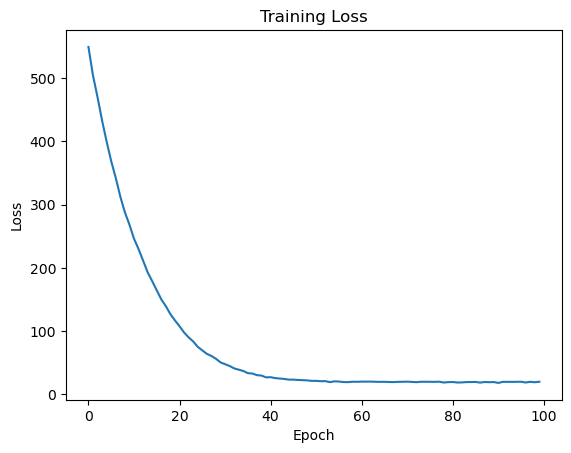

In [43]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

Text(0, 0.5, 'Predicted MPG')

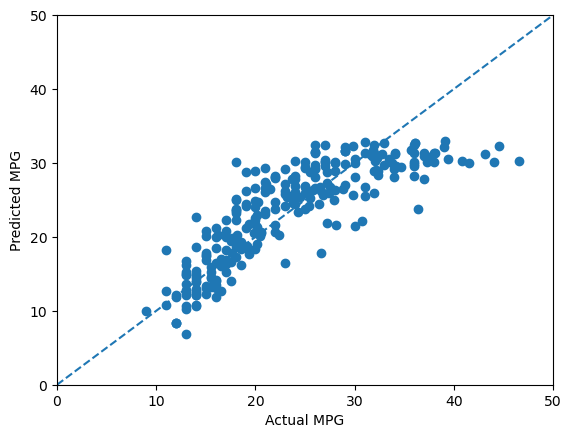

In [44]:
plt.scatter(train_ds[:][1], model(train_ds[:][0].to(device)).tolist())
plt.plot([0, 50], [0, 50], linestyle='--')
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')

## 2.9 Evaluation

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

In [45]:
torch.manual_seed(13)
linear = nn.Linear(in_features=1, out_features=1, bias=True)

model = nn.Sequential()
model.add_module('layer1', linear)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.1)

### 2.9.2 Evaluation Mode

In [46]:
n_epochs = 100

losses = torch.empty(n_epochs)
val_losses = torch.empty(n_epochs)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

train_loader.sampler.generator.manual_seed(13)

for epoch in range(n_epochs):
    batch_losses = torch.empty(len(train_loader))
    
    ## Training
    for i, (batch_features, batch_targets) in enumerate(train_loader):
        model.train()
        
        batch_features= batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        # Step 1 - forward pass
        predictions = model(batch_features)

        # Step 2 - computing the loss
        loss = loss_fn(predictions, batch_targets)

        # Step 3 - computing the gradients
        loss.backward()
        batch_losses[i] = loss.item()

        # Step 4 - updating parameters and zeroing gradients
        optimizer.step()
        optimizer.zero_grad()
        
    losses[epoch] = batch_losses.mean()

    ## Validation
    batch_losses = torch.empty(len(val_loader))
    
    # Sprinkle
    with torch.inference_mode():
        for i, (val_features, val_targets) in enumerate(val_loader):
            # Sprinkle
            model.eval()
            
            val_features= val_features.to(device)
            val_targets = val_targets.to(device)

            # Step 1 - forward pass
            predictions = model(val_features)

            # Step 2 - computing the loss
            loss = loss_fn(predictions, val_targets)
            batch_losses[i] = loss.item()

        val_losses[epoch] = batch_losses.mean()

In [49]:
model.state_dict()

OrderedDict([('layer1.weight', tensor([[-6.6773]])),
             ('layer1.bias', tensor([23.5291]))])

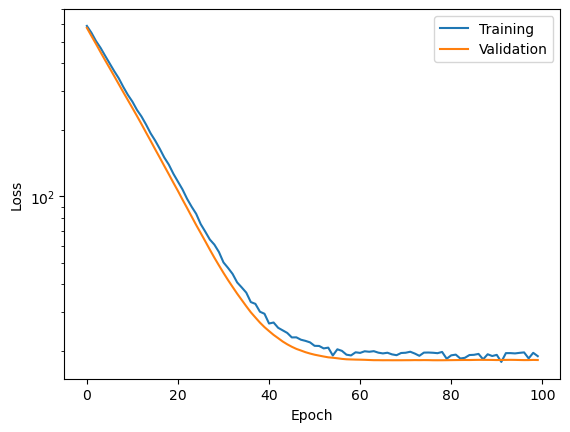

In [50]:
plt.plot(losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

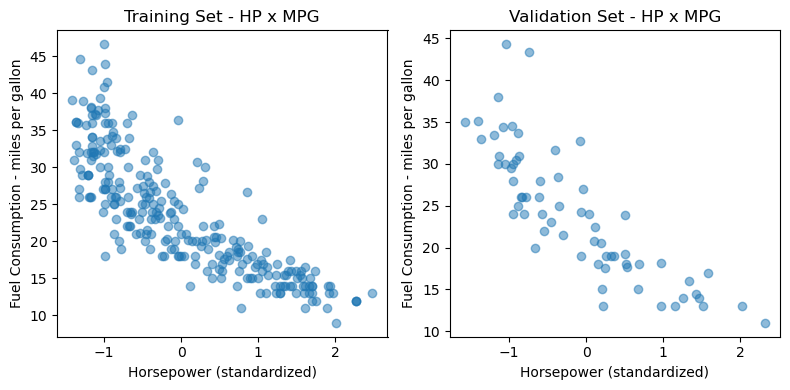

In [51]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(train_ds[:][0], train_ds[:][1], alpha=0.5)
axs[0].set_xlabel('Horsepower (standardized)')
axs[0].set_ylabel('Fuel Consumption - miles per gallon')
axs[0].set_title('Training Set - HP x MPG')
axs[1].scatter(val_ds[:][0], val_ds[:][1], alpha=0.5)
axs[1].set_xlabel('Horsepower (standardized)')
axs[1].set_ylabel('Fuel Consumption - miles per gallon')
axs[1].set_title('Validation Set - HP x MPG')
fig.tight_layout()

## 2.10 Saving and Loading Models

In [52]:
def save_checkpoint(model, optimizer, filename):
    checkpoint = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()}

    torch.save(checkpoint, filename)

In [53]:
def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

### 2.10.2 Early Stopping

In [54]:
torch.manual_seed(13)
linear = nn.Linear(in_features=1, out_features=1, bias=True)

model = nn.Sequential()
model.add_module('layer1', linear)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(params=model.parameters(), lr=0.1)

In [55]:
n_epochs = 100

losses = torch.empty(n_epochs)
val_losses = torch.empty(n_epochs)

# Early stopping
best_loss = torch.inf
best_epoch = -1
patience = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

train_loader.sampler.generator.manual_seed(13)

for epoch in range(n_epochs):
    batch_losses = torch.empty(len(train_loader))
    
    ## Training
    for i, (batch_features, batch_targets) in enumerate(train_loader):
        model.train()
        
        batch_features = batch_features.to(device)
        batch_targets = batch_targets.to(device)
        
        # Step 1 - forward pass
        predictions = model(batch_features)

        # Step 2 - computing the loss
        loss = loss_fn(predictions, batch_targets)

        # Step 3 - computing the gradients
        loss.backward()
        batch_losses[i] = loss.item()

        # Step 4 - updating parameters and zeroing gradients
        optimizer.step()
        optimizer.zero_grad()
        
    losses[epoch] = batch_losses.mean()

    ## Validation   
    with torch.inference_mode():
        batch_losses = torch.empty(len(val_loader))    

        for i, (val_features, val_targets) in enumerate(val_loader):
            model.eval()

            val_features = val_features.to(device)
            val_targets = val_targets.to(device)

            # Step 1 - forward pass
            predictions = model(val_features)

            # Step 2 - computing the loss
            loss = loss_fn(predictions, val_targets)
            batch_losses[i] = loss.item()

        val_losses[epoch] = batch_losses.mean()
        
        # Early stopping
        if val_losses[epoch] < best_loss:
            best_loss = val_losses[epoch]
            best_epoch = epoch
            save_checkpoint(model, optimizer, "best_model.pth")
        elif (epoch - best_epoch) > patience:
            print(f"Early stopping at epoch #{epoch}")
            break

Early stopping at epoch #71


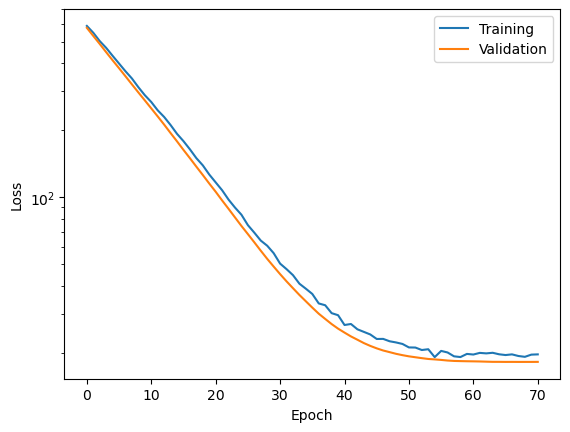

In [61]:
plt.plot(losses[:epoch], label='Training')
plt.plot(val_losses[:epoch], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

In [57]:
# No need to set a seed, we'll be loading a trained model
linear = nn.Linear(in_features=1, out_features=1, bias=True)
model = nn.Sequential()
model.add_module('layer1', linear)
model.state_dict()

OrderedDict([('layer1.weight', tensor([[-0.1630]])),
             ('layer1.bias', tensor([-0.2799]))])

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

load_checkpoint(model, None, 'best_model.pth')

model.eval()
model.to(device)

Sequential(
  (layer1): Linear(in_features=1, out_features=1, bias=True)
)

In [59]:
model.state_dict()

OrderedDict([('layer1.weight', tensor([[-6.6750]])),
             ('layer1.bias', tensor([23.3032]))])

In [62]:
val_features, val_targets = next(iter(val_loader))
val_features = val_features.to(device)
with torch.inference_mode():
    pred = model(val_features).cpu()
    
torch.cat([val_targets, pred], axis=1)

tensor([[18.0000, 22.2504],
        [26.0000, 28.8320],
        [24.0000, 29.6547],
        [23.9000, 19.9515],
        [23.0000, 26.3178],
        [35.1000, 32.7149],
        [35.0000, 33.8451],
        [19.0000, 21.5585],
        [22.5000, 22.5272],
        [33.0000, 32.4458],
        [28.0000, 27.3020],
        [43.4000, 28.2938],
        [11.0000,  7.8263],
        [33.5000, 31.2924],
        [26.0000, 27.4019],
        [16.9000, 12.7240],
        [20.0000, 27.7325],
        [13.0000,  9.8408],
        [24.0000, 23.0885],
        [14.0000, 13.5160],
        [26.0000, 28.9781],
        [17.5000, 21.6969],
        [19.0000, 21.1509],
        [44.3000, 30.2160],
        [15.0000, 18.8520],
        [30.9000, 29.1011],
        [13.0000, 16.8683],
        [19.0000, 23.7190],
        [30.5000, 29.4087],
        [24.0000, 28.7321],
        [28.4000, 25.7181],
        [19.0000, 20.8588]])

## 2.11 Non-Linearities
    
![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)
    
|Linear  |Non-Linear  |
|---|---|
| ![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch3/linear_boundary.png) | ![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch3/non_linear_boundaries.png) |